# TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL
- 본 튜토리얼에선 **이미지 분류를 위한 CNN 을 전이 학습을 이용해 학습하는 방법**을 배울 것
>실질적으로 CNN 을 scratch 단계(with random 초기화)에서부터 전체를 학습하는 사람들은 거의 없다.  
이유는 CNN 을 학습하기 충분한 크기의 데이터셋을 확보하기 어렵기 때문  
그래서 대신에, **대규모 데이터셋에 사전학습된 CNN 을 초기모델로 사용하거나 특성 추출기로 사용하는 경우**가 많음

**전이 학습의 두 가지 대표 시나리오**
1. **Finetuning the convnet** : 무작위로 초기화된 모델을 사용하는 것이 아니라 사전 학습된 모델을 초기화 삼아 사용
2. **ConvNet as fixed feature extractor** : 마지막 출력층을 제외한 모든 층을 freeze 하여 사용. 마지막 출력층은 사용자의 목적에 따라 새롭게 대체되어 그 부분만 학습하여 사용

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

---
# 1. Load Data
- 데이터를 로드하기 위해 **torchvision** 과 **torch.utils.data** 패키지를 이용할 것
- 이 튜토리얼에서 우리가 해결해야 할 문제는 **개미와 벌을 구분하는 모델을 만드는 것**
- 각 클래스당 120개의 학습 이미지가 있음. 각 클래스당 75개의 검증 이미지가 있음.
- 일반적으로 이는 일반화하기엔 매우 작은 데이터셋임. 
- 이를 전이 학습을 통해 보완하고자 함

In [9]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "../../datasets/hymenoptera_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                          data_transforms[x])
                 for x in ["train", "val"]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, 
                                              shuffle=True, num_workers=0)
              for x in ["train", "val"]}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

---
# 2. Visualize a few images

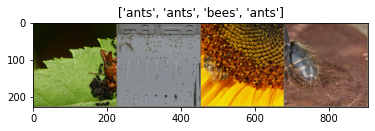

In [12]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
inputs, classes = next(iter(dataloaders["train"]))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

---
# 3. Training the model
>**모델을 학습하기 위해 작성할 함수들**
>- 학습률 스케줄링
>- best 모델 저장

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print("-"*10)
        
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            running_loss = 0.
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == "train":
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print("{} loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val Acc: {:4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

---
# 4. Visualizing the model prediction

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("predicted: {}".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

---
# 5. Finetuning the convnet
- 사전학습된 모델을 로드하고 마지막 fc 층을 리셋함

In [15]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

---
# 6. Train and evaluate

In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train loss: 0.6524 Acc: 0.6844
val loss: 0.3374 Acc: 0.8693

Epoch 1/24
----------
train loss: 0.4735 Acc: 0.7992
val loss: 0.3182 Acc: 0.8627

Epoch 2/24
----------
train loss: 0.3963 Acc: 0.8238
val loss: 0.3130 Acc: 0.8824

Epoch 3/24
----------
train loss: 0.6284 Acc: 0.7828
val loss: 0.3209 Acc: 0.8627

Epoch 4/24
----------
train loss: 0.5786 Acc: 0.7623
val loss: 0.3746 Acc: 0.8105

Epoch 5/24
----------
train loss: 0.5106 Acc: 0.7746
val loss: 0.2739 Acc: 0.9085

Epoch 6/24
----------
train loss: 0.5136 Acc: 0.7746
val loss: 0.2659 Acc: 0.8954

Epoch 7/24
----------
train loss: 0.3863 Acc: 0.8443
val loss: 0.2521 Acc: 0.9150

Epoch 8/24
----------
train loss: 0.3757 Acc: 0.8320
val loss: 0.2313 Acc: 0.9085

Epoch 9/24
----------
train loss: 0.2932 Acc: 0.8770
val loss: 0.2428 Acc: 0.8954

Epoch 10/24
----------
train loss: 0.3777 Acc: 0.8115
val loss: 0.2309 Acc: 0.9346

Epoch 11/24
----------
train loss: 0.2894 Acc: 0.8770
val loss: 0.2110 Acc: 0.9346

Ep

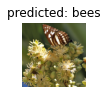

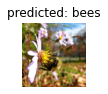

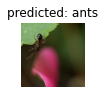

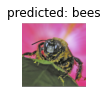

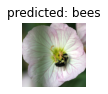

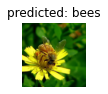

In [19]:
visualize_model(model_ft)

---
# 7. ConvNet as fixed feature extractor
- 여기선 사전학습한 모델의 모든 층을 ```requires_grad=False``` 로 설정하여 학습이 되지 않게 함
- 마지막 추가한 fc층만 학습하여 시간을 훨씬 단축(물론 성능은 이전만큼 보장 못함)

In [22]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma = 0.1)

In [25]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train loss: 0.5620 Acc: 0.6721
val loss: 0.2329 Acc: 0.9281

Epoch 1/24
----------
train loss: 0.4782 Acc: 0.7869
val loss: 0.3893 Acc: 0.8301

Epoch 2/24
----------
train loss: 0.5853 Acc: 0.7787
val loss: 0.2817 Acc: 0.8824

Epoch 3/24
----------
train loss: 0.5988 Acc: 0.7705
val loss: 0.2856 Acc: 0.8824

Epoch 4/24
----------
train loss: 0.4290 Acc: 0.8074
val loss: 0.2970 Acc: 0.8824

Epoch 5/24
----------
train loss: 0.3923 Acc: 0.8279
val loss: 0.2695 Acc: 0.9085

Epoch 6/24
----------
train loss: 0.4391 Acc: 0.8238
val loss: 0.2932 Acc: 0.9085

Epoch 7/24
----------
train loss: 0.4217 Acc: 0.7910
val loss: 0.1852 Acc: 0.9346

Epoch 8/24
----------
train loss: 0.3005 Acc: 0.8811
val loss: 0.1832 Acc: 0.9281

Epoch 9/24
----------
train loss: 0.3619 Acc: 0.8361
val loss: 0.1915 Acc: 0.9281

Epoch 10/24
----------
train loss: 0.4294 Acc: 0.8115
val loss: 0.1914 Acc: 0.9477

Epoch 11/24
----------
train loss: 0.3973 Acc: 0.8238
val loss: 0.2078 Acc: 0.9281

Ep